# Prediction Analysis

This notebook is an exploratory analysis to dig a little bit inside the data an experiment some techniques on how we can approach the problem of predicting sales at the company snacks co.

In [1]:
import datetime
import random
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.stats as stats
import statsmodels.api as sm

from statsmodels.formula.api import ols


random.seed(42)

In [2]:
dateparse = lambda x: pd.datetime.strptime(x, '%d/%m/%Y')

snacks_df = pd.read_csv('./datasets/clean_snacks.csv', dtype={ 'client_id': str }, parse_dates=['date'], date_parser=dateparse)
snacks_df['product_id'] = snacks_df['product_id'].astype(str)
snacks_df.head(1)

,office,warehouse,category,brand,product_id,flavor,client,point_of_sale,distributor,date,units,devolution_units,sale_amount,sale_discount,sale_devolution,incentive
0,Cali,Tulua,Producto De Extrusion,Cheetos,53407164,Tradicional,NaN,NaN,Tiendas,2014-04-01,324,0,181530.0,32675.4,-0.0,True


Let's look at the distribution for amount of sale units.

In [3]:
sum(snacks_df['units'] == 0)

48850

We have a lot of records having 0 units, this is because those records represent returns of the product, right now we are not interested in analyze that part, so we will remove 0 units from the df.

In [4]:
snacks_df = snacks_df[snacks_df['units'] > 0]

This is a very complicated distribution, we have huge outliers that makes the histogram useless because we cannot se anything, let's make a simple logarithmic transformation and see if that helps.

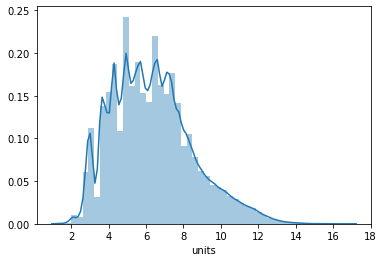

In [5]:
sns.distplot(np.log(snacks_df['units']))

With the transformation now we can see a little bit more of the behavior of the data and we can see something that kind of looks like a normal distribution, interesting to see here is that the distributions reflects that probably the units are in rounded numbers, something like 1000, 2000, 3000... that makes sense because it's kind of expected that companies do their orders in rounde numbers.

Because it's not useful to predict the whole unit sales of the company we need to dig a little bit and see if we can predict the amount of units that are going to sale for a particular product (Simpsons paradox).

To explore this idea, we need to ask two questions:

* What are the products with more sale units in the dataset?
* What are the products with more records in the dataset?

This questions are ask in order to start from a product that will probably have enough data to do an exploration and test the idea of doing a prediction, if the idea can be tested in this product, we can generalize it and use it for other products.

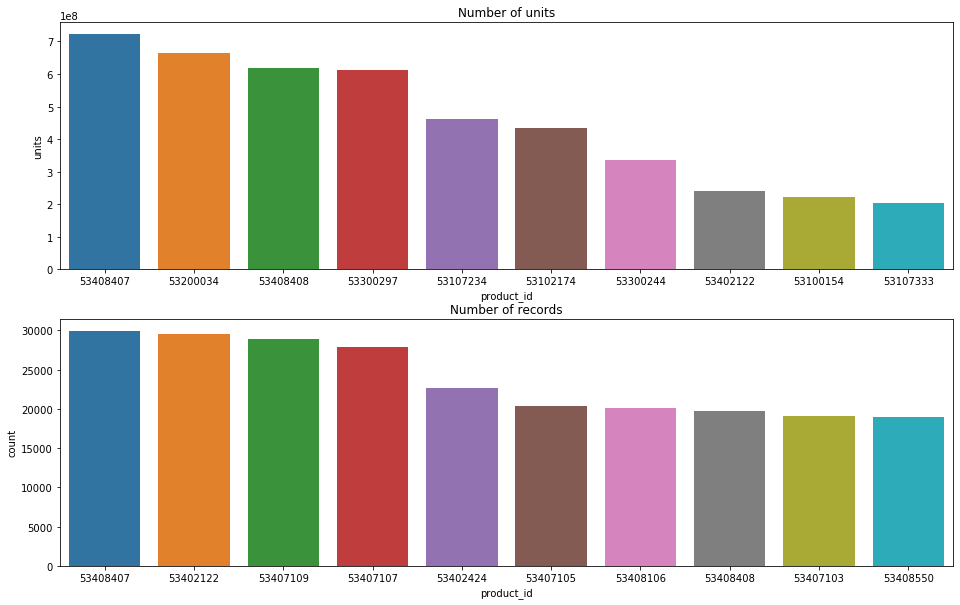

In [6]:
top_products_units = snacks_df.groupby('product_id')['units'].sum().reset_index().sort_values('units', ascending=False).head(10)
top_products_records = snacks_df.groupby('product_id')['units'].count().reset_index().rename(columns={ 'units': 'count' }).sort_values('count', ascending=False).head(10)

plt.figure(figsize=(16, 10))
plt.subplot(2, 1, 1).set_title('Number of units')
sns.barplot(x='product_id', y='units', data=top_products_units, order=top_products_units['product_id'])
plt.subplot(2, 1, 2).set_title('Number of records')
sns.barplot(x='product_id', y='count', data=top_products_records, order=top_products_records['product_id'])

luckily for us the product with more sales units is also the one with the most amount of records, let's see what products accomplish the two conditions.

In [7]:
interesting_products = list(set(top_products_units['product_id']).intersection(set(top_products_records['product_id'])))
interesting_products

['53408408', '53408407', '53402122']

We have three products, let's anallyse the distributions of those products.

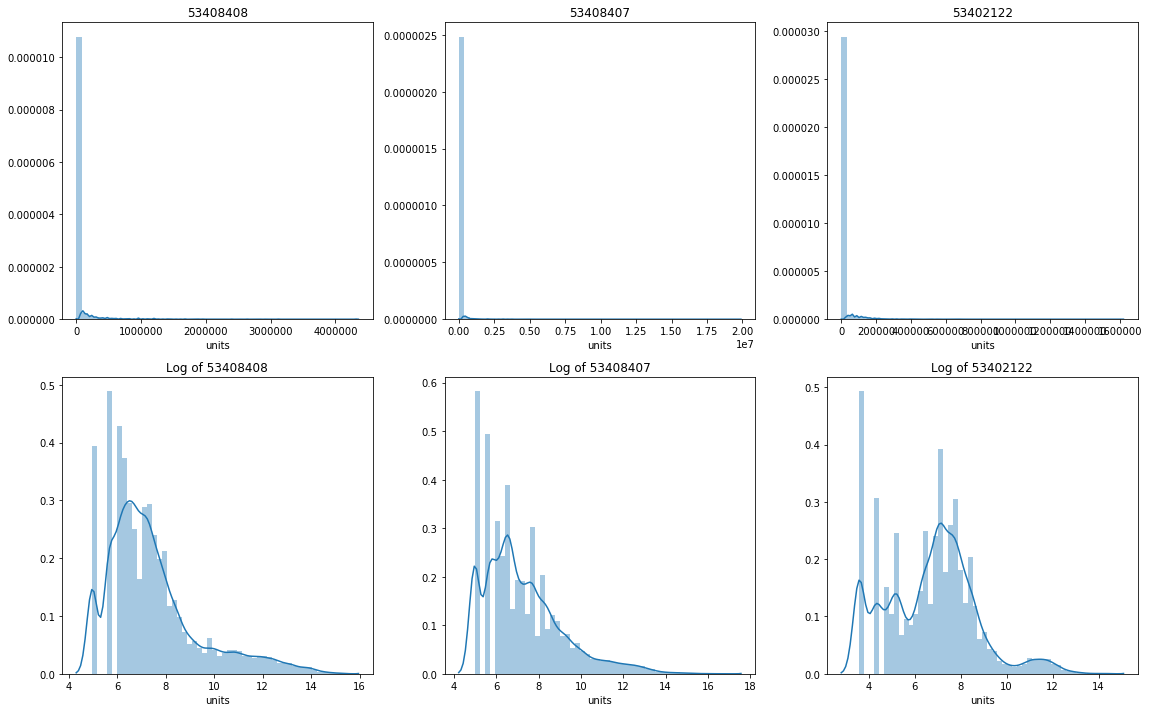

In [8]:
plt.figure(figsize=(16, 10))

for index, product_id in enumerate(interesting_products):
    plt.subplot(2, 3, index + 1)
    sns.distplot(snacks_df[snacks_df['product_id'] == product_id]['units']).set_title(product_id)

for index, product_id in enumerate(interesting_products):
    plt.subplot(2, 3, index + 4)
    sns.distplot(np.log(snacks_df[snacks_df['product_id'] == product_id]['units'])).set_title(f"Log of {product_id}")

plt.tight_layout()

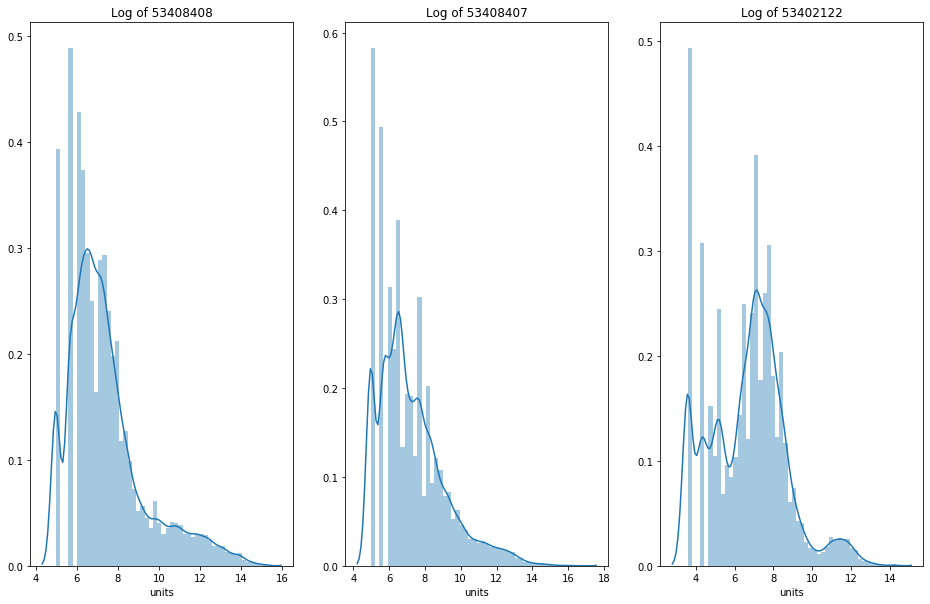

In [9]:
plt.figure(figsize=(16, 10))
for index, product_id in enumerate(interesting_products):
    plt.subplot(1, 3, index + 1)
    sns.distplot(np.log(snacks_df[snacks_df['product_id'] == product_id]['units'])).set_title(f"Log of {product_id}")

We are still having very problematic distributions, we can ask? why are some records with such a high number of units? this kind of orders are atypical? what can we do this that kind of data?

In [10]:
product_id = '53408408'

product_df = snacks_df[snacks_df['product_id'] == product_id]
max_limit = product_df['units'].quantile(0.8)

outliers_df = product_df[product_df['units'] > max_limit]

f"We have {len(outliers_df)} outliers from the total of {len(product_df)} records, having a limit on the outliers of {max_limit} units"

'We have 3868 outliers from the total of 19722 records, having a limit on the outliers of 4896.0 units'

Let's look at the distribution of the data separated and see if there is something interesting.

Text(0.5, 1.0, 'outliers')

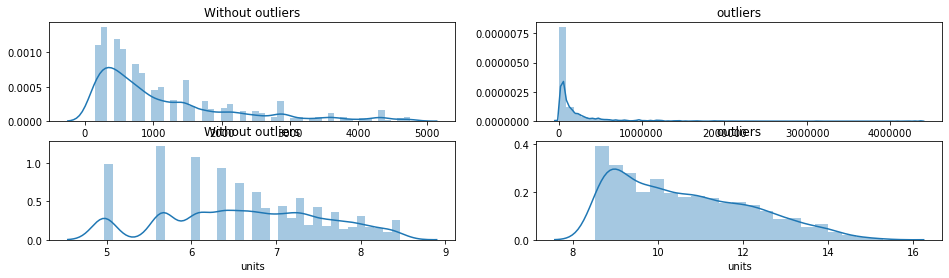

In [11]:
plt.figure(figsize=(16, 4))

plt.subplot(2, 2, 1)
sns.distplot(product_df[product_df['units'] < max_limit]['units']).set_title('Without outliers')
plt.subplot(2, 2, 2)
sns.distplot(outliers_df['units']).set_title('outliers')

plt.subplot(2, 2, 3)
sns.distplot(np.log(product_df[product_df['units'] < max_limit]['units'])).set_title('Without outliers')
plt.subplot(2, 2, 4)
sns.distplot(np.log(outliers_df['units'])).set_title('outliers')

We can see that the orders have a very wide range that makes difficult to visualize the distributions, but with the last split we improved a little bit the distribution removing the outliers on the sales using as a threshold the quantile **0.8**, we are having a lot of outliers so we cannot simply remove those from the dataset, if we do not include that information, the outliers will obscure any prediction that we can achieve, we can ask the following question:

* Those high unit orders correspond to some special dates?
* What are the offices that produces those kind of sales?
* What are the clients that make such a hight unit orders?

In [12]:
outliers_df['date'].min(), outliers_df['date'].max()

(Timestamp('2014-04-01 00:00:00'), Timestamp('2018-04-01 00:00:00'))

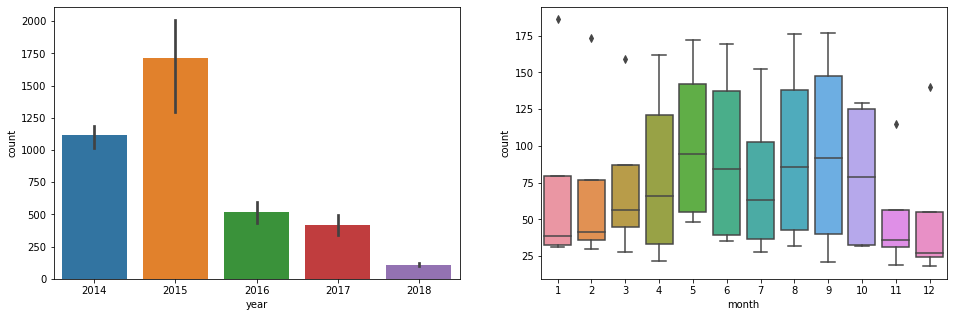

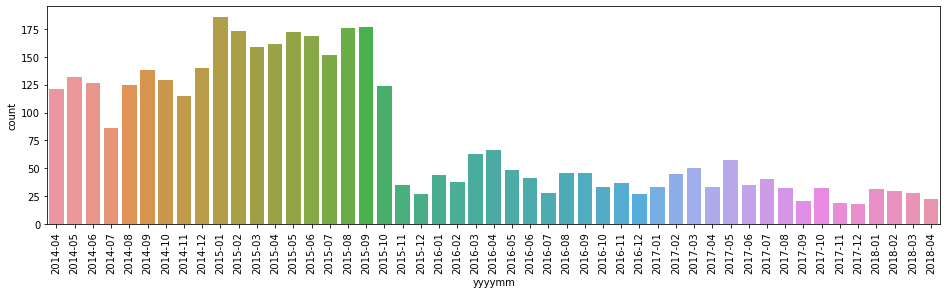

In [13]:
data = outliers_df.groupby('date')['units'].count().reset_index().rename(columns={ 'units': 'count' })
data['year'] = data['date'].dt.year
data['month'] = data['date'].dt.month
data['yyyymm'] = data['date'].dt.to_period('M')

plt.figure(figsize=(16, 5))

plt.subplot(1, 2, 1)
sns.barplot(x='year', y='count', estimator=sum, data=data)

plt.subplot(1, 2, 2)
sns.boxplot(x='month', y='count', data=data)

plt.figure(figsize=(16, 4))

chart = sns.barplot(x='yyyymm', y='count', data=data)
chart.set_xticklabels(chart.get_xticklabels(), rotation=90)
plt.show()

We cannot see interesting patterns, from this data we can see that 2014 and 2015 are a lot of orders as outliers, since the 2015 the outliers ordes seems to be decreasing, maybe that is because the personal is getting more disciplined with the orders and registering those as more atomic transactions.

Also is interesting to see that months 5 and 9 are the ones in average with the most outliers.

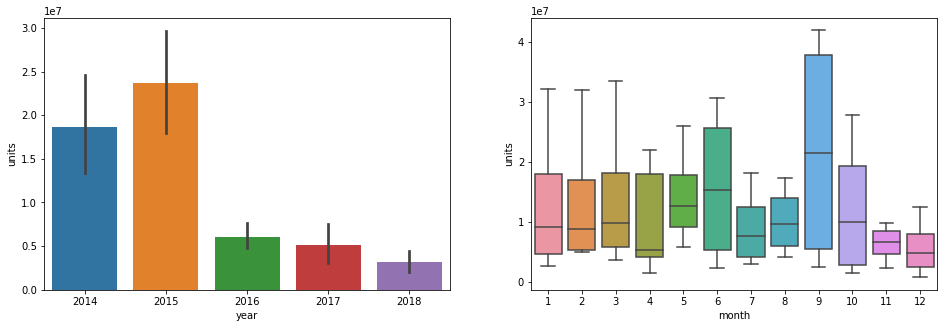

In [14]:
data = outliers_df.groupby('date')['units'].sum().reset_index()
data['year'] = data['date'].dt.year
data['month'] = data['date'].dt.month
data['yyyymm'] = data['date'].dt.to_period('M')

plt.figure(figsize=(16, 5))

plt.subplot(1, 2, 1)
sns.barplot(x='year', y='units', data=data)

plt.subplot(1, 2, 2)
sns.boxplot(x='month', y='units', data=data)

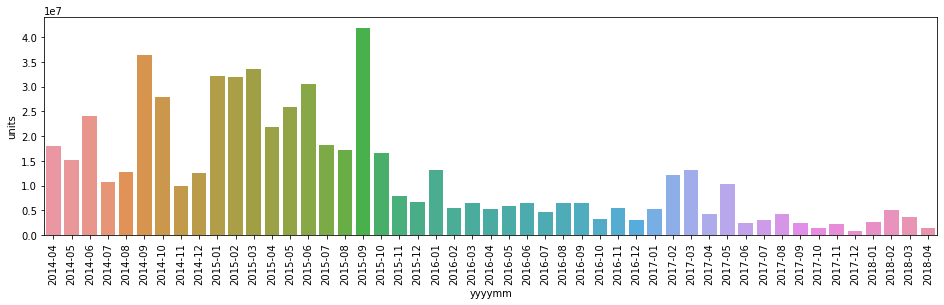

In [15]:
plt.figure(figsize=(16, 4))

chart = sns.barplot(x='yyyymm', y='units', data=data)
chart.set_xticklabels(chart.get_xticklabels(), rotation=90)
plt.show()

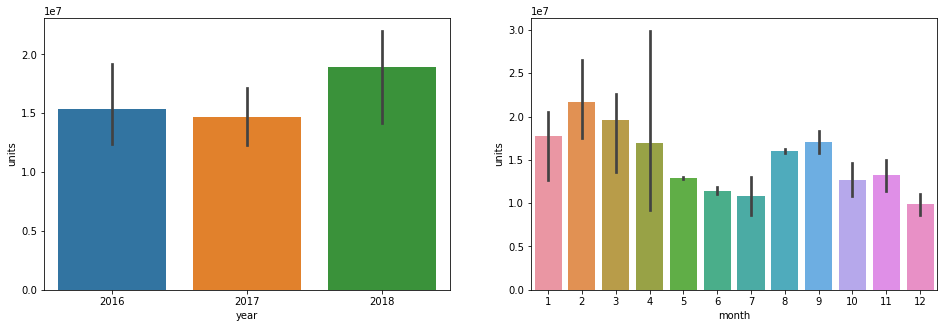

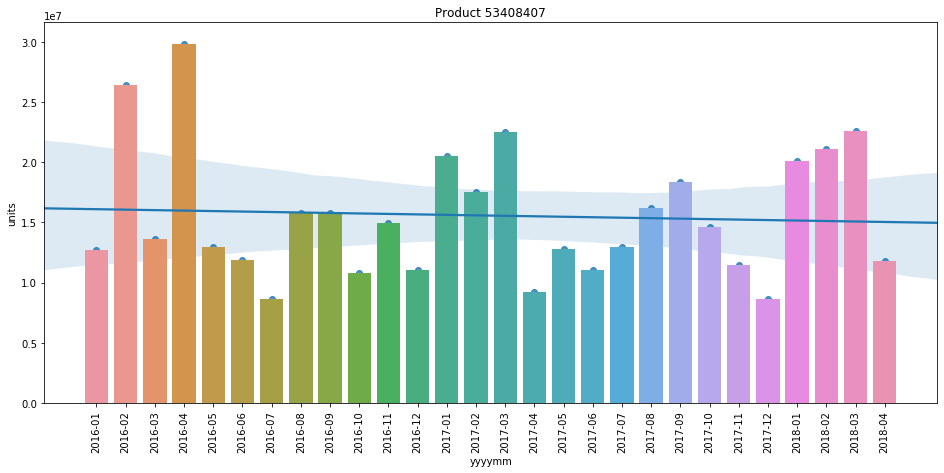

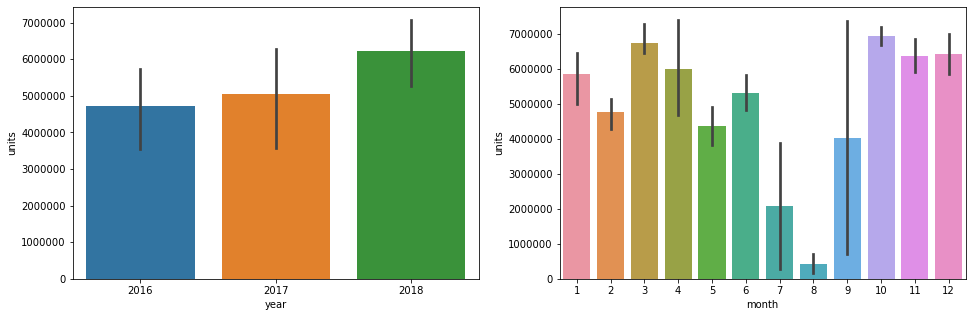

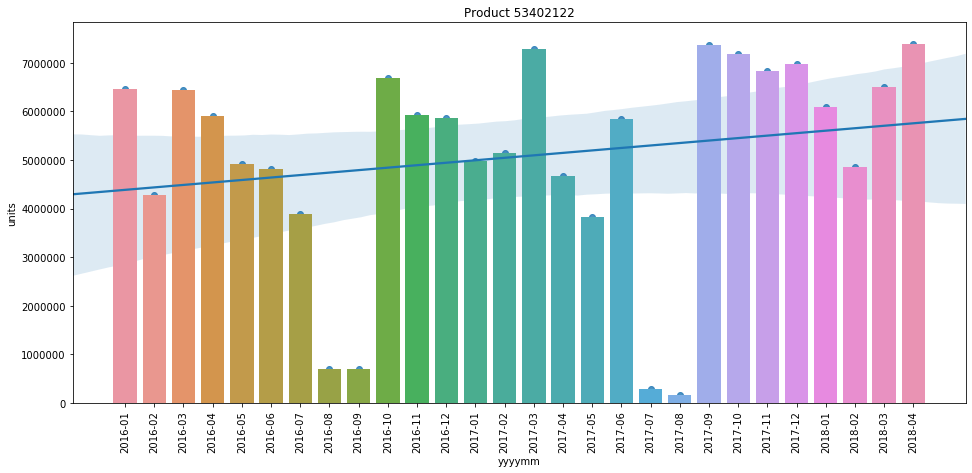

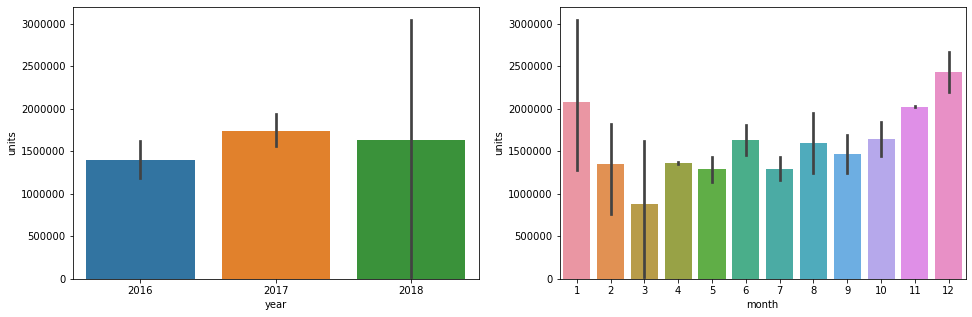

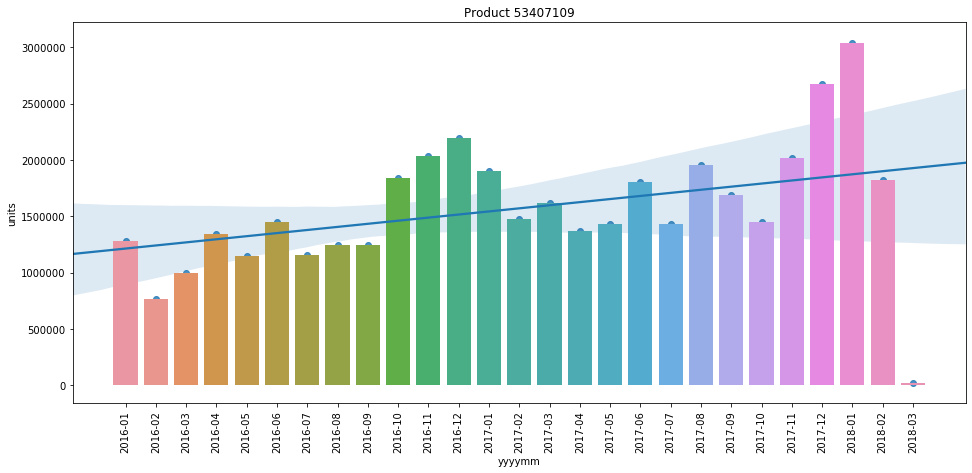

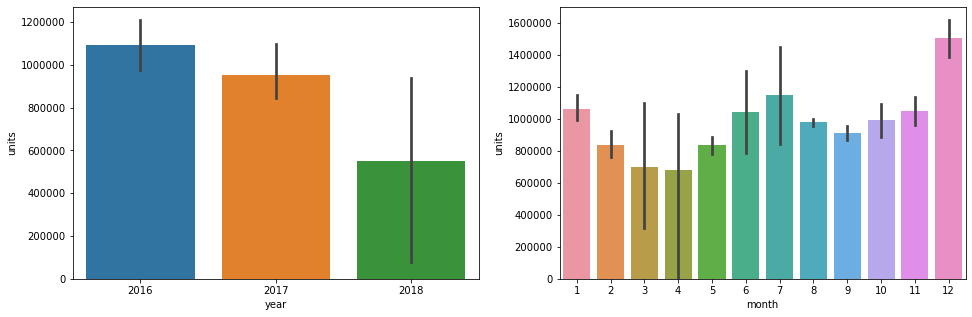

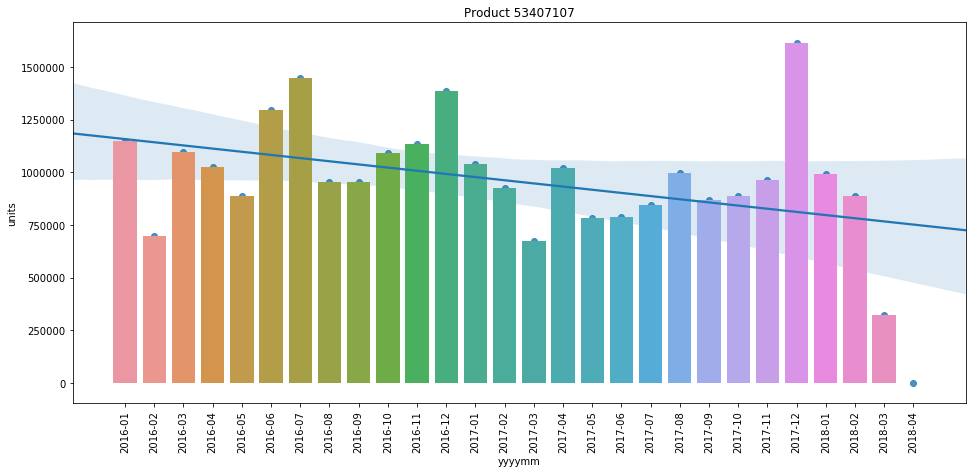

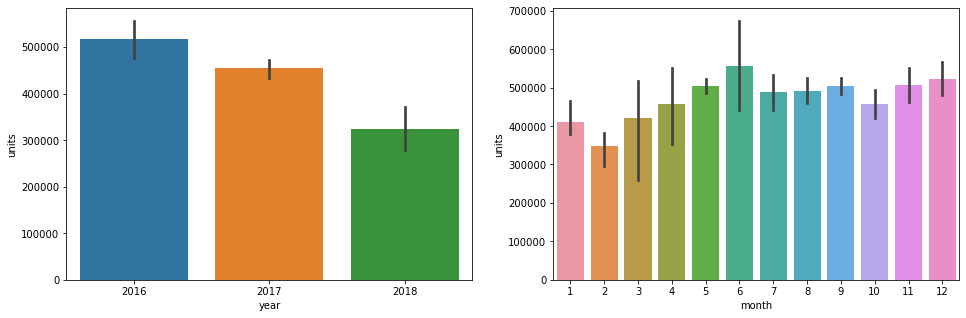

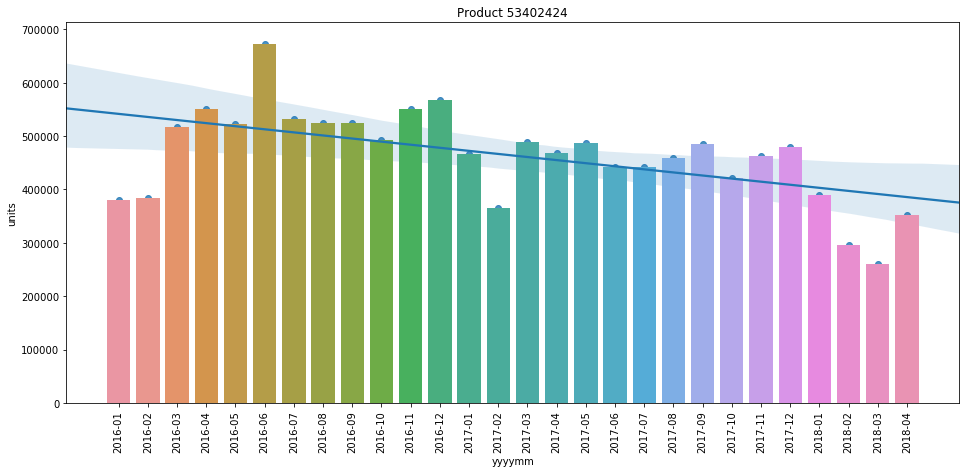

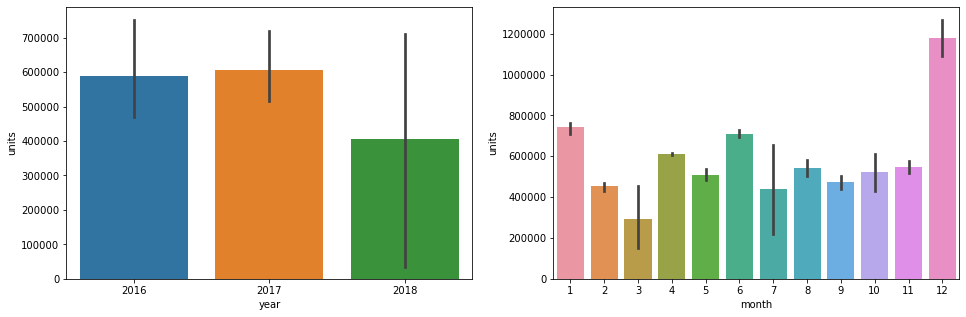

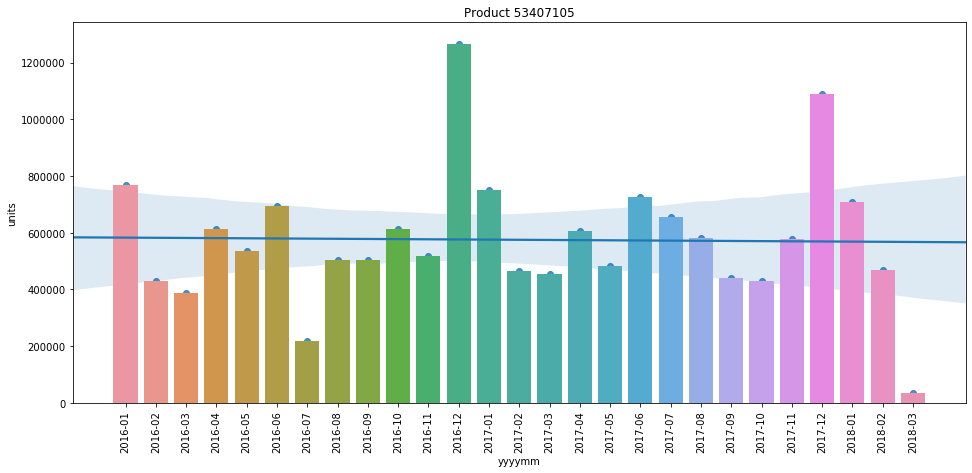

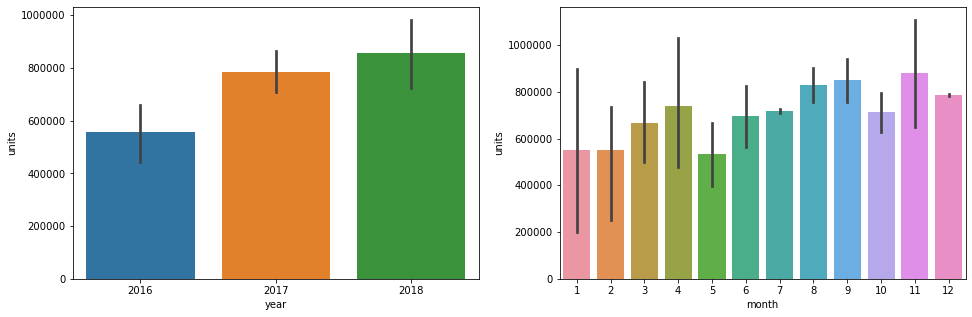

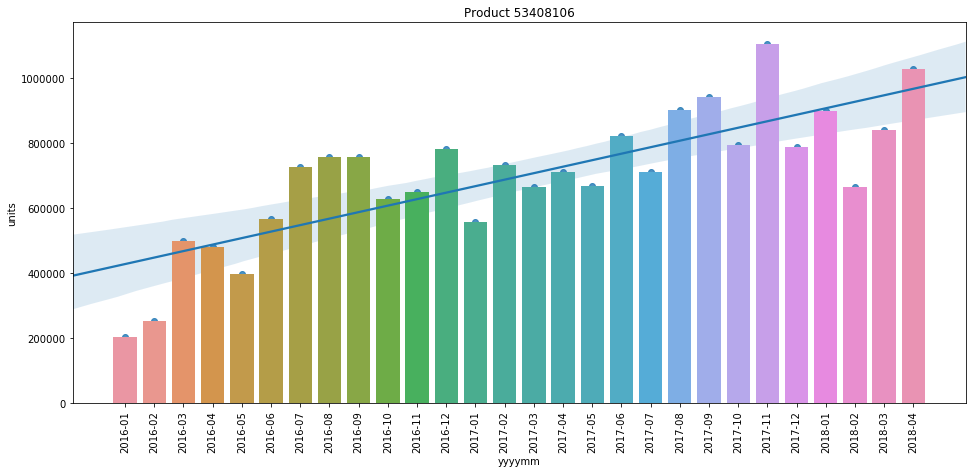

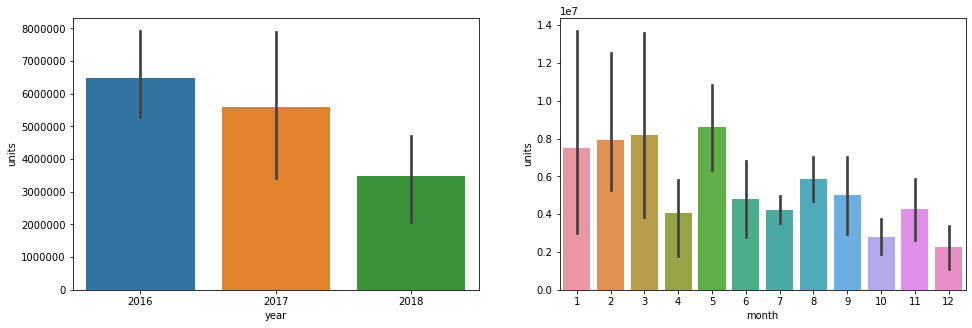

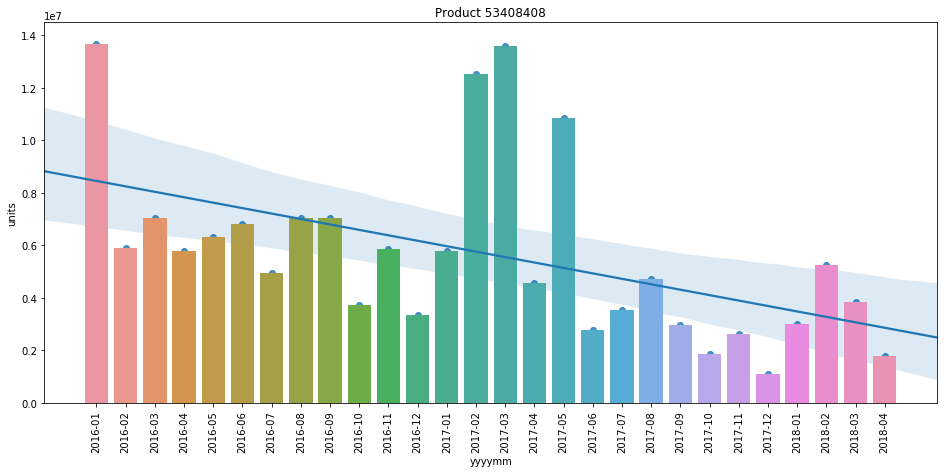

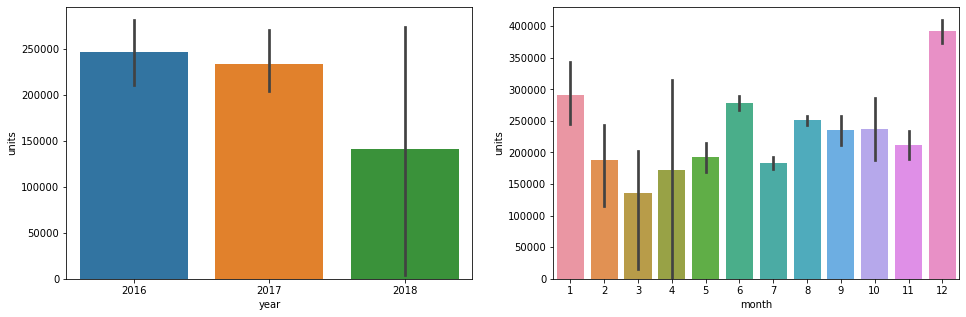

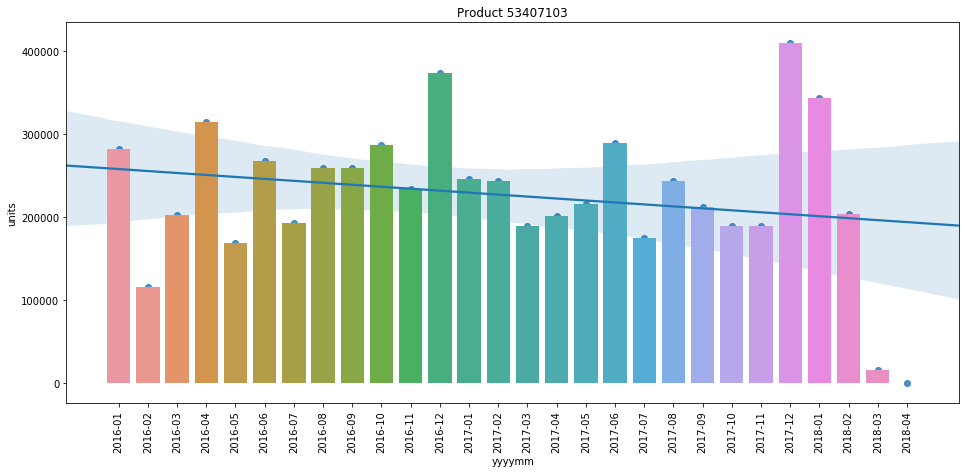

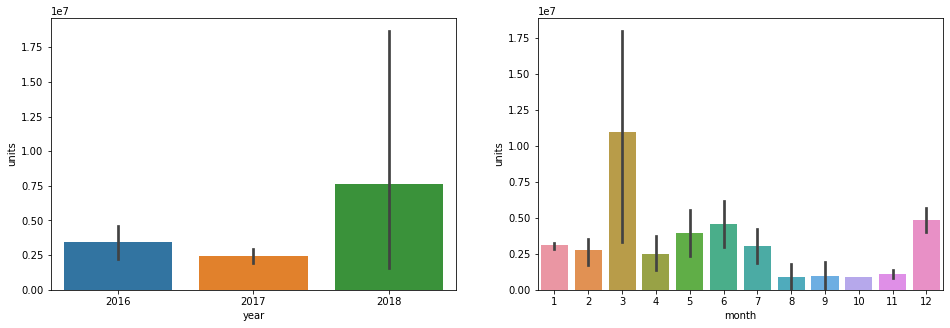

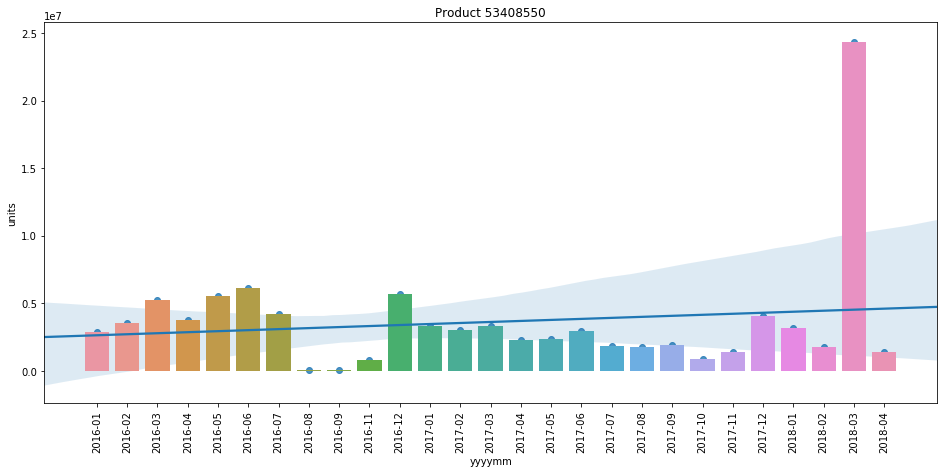

In [16]:
import datetime
from statsmodels.formula.api import ols

# products = snacks_df['product_id'].unique()
# products = products[np.random.choice(len(products), 10)]
products = top_products_records['product_id'].values

models = {}

# column = 'log_units'
column = 'units'

for index, product_id in enumerate(products):
    data_df = snacks_df[snacks_df['product_id'] == product_id]
    data_df = data_df.groupby('date')['units'].sum().reset_index()
    data_df['year'] = data_df['date'].dt.year
    data_df['month'] = data_df['date'].dt.month
    data_df['yyyymm'] = data_df['date'].dt.to_period('M')
    data_df = data_df[data_df['yyyymm'] >= datetime.date(year=2016, month=1, day=1)].reset_index()
    data_df['log_units'] = np.log(data_df['units'])
    data_df['index_value'] = data_df.index
    
    if len(data_df):
        plt.figure(figsize=(16, 5))
        
        plt.subplot(1, 2, 1)
        sns.barplot(x='year', y=column, data=data_df)
        
        plt.subplot(1, 2, 2)
        sns.barplot(x='month', y=column, data=data_df)
        plt.show()
        
        plt.figure(figsize=(16, 7))
        chart = sns.barplot(x='yyyymm', y=column, data=data_df)
        sns.regplot(x = np.arange(0, len(data_df)), y=data_df[column], ax=chart)
        chart.set_xticklabels(chart.get_xticklabels(), rotation=90)
        chart.set_title(f"Product {product_id}")
        plt.show()
        
        # How can i make the linear regression??
        models[product_id] = ols('np.log(units) ~ index_value', data=data_df).fit()  

In [17]:
for key, value in models.items():
    slope = value.params['index_value']
    print(f"The slope for the product {key} is: {slope} and R-squared: {value.rsquared}")

The slope for the product 53408407 is: -0.0011759444127058677 and R-squared: 0.0008627607407586391
The slope for the product 53402122 is: 0.0037923778900143673 and R-squared: 0.0009599685271651781
The slope for the product 53407109 is: -0.009259064097055736 and R-squared: 0.006916706705072384
The slope for the product 53407107 is: -0.07866691895315145 and R-squared: 0.13575491342569634
The slope for the product 53402424 is: -0.013365051535462871 and R-squared: 0.29531898702138737
The slope for the product 53407105 is: -0.014717090962842294 and R-squared: 0.034575905761192405
The slope for the product 53408106 is: 0.03474574015428869 and R-squared: 0.568855767946016
The slope for the product 53408408 is: -0.045536740046373064 and R-squared: 0.3774991667847596
The slope for the product 53407103 is: -0.06274788415325047 and R-squared: 0.1456117100782779
The slope for the product 53408550 is: 0.00860198503847237 and R-squared: 0.00285769629018362


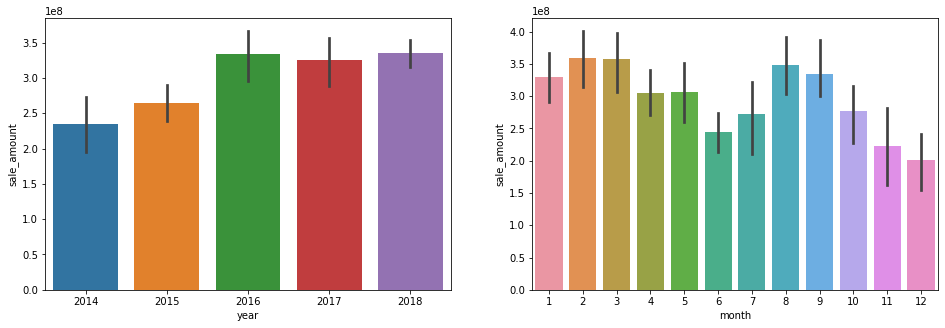

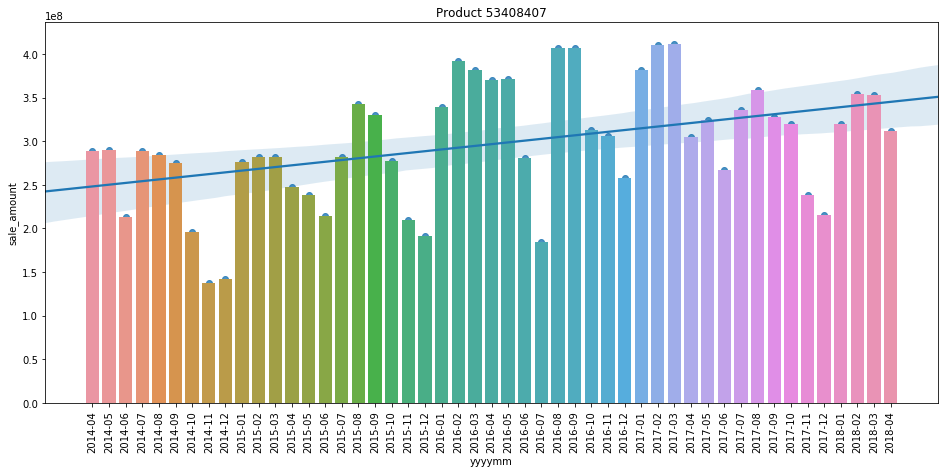

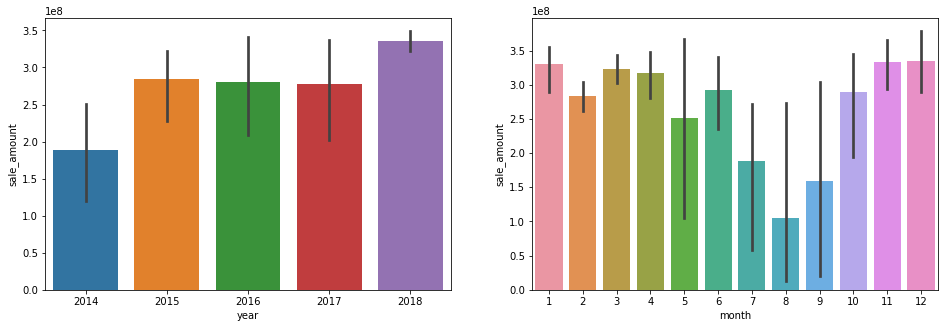

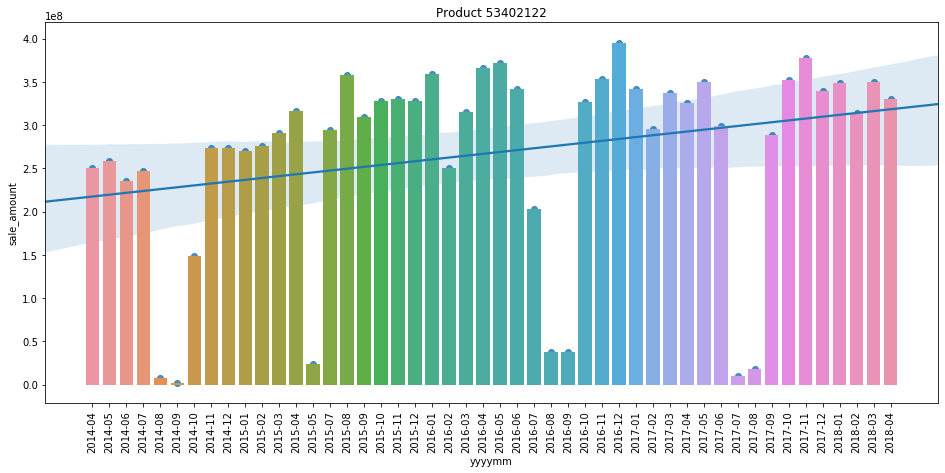

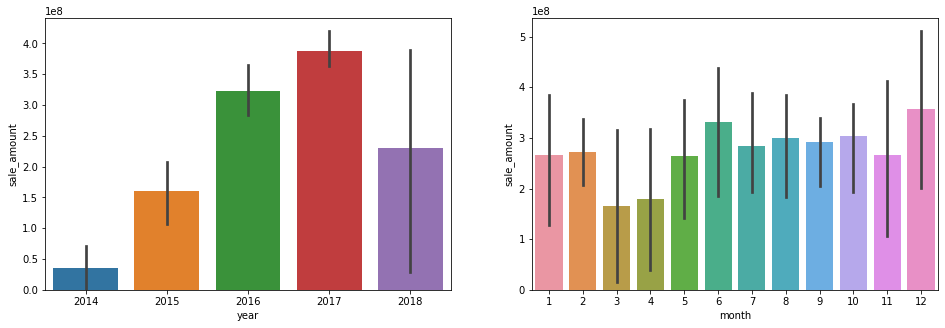

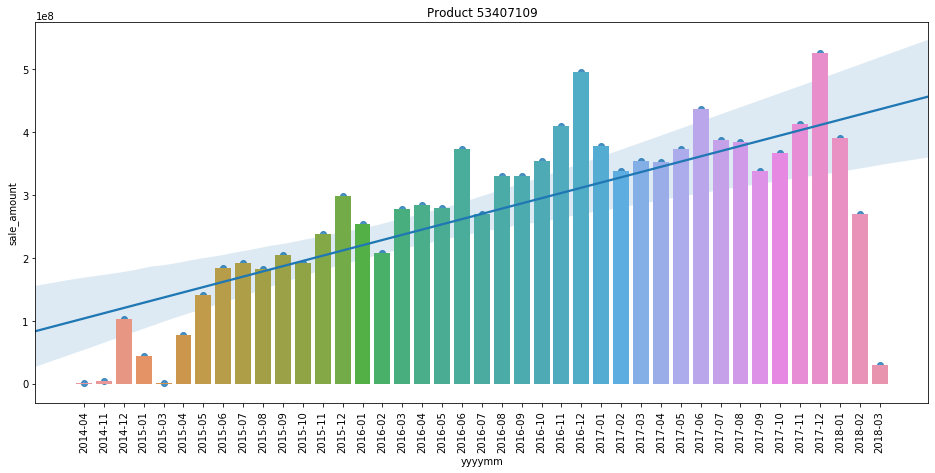

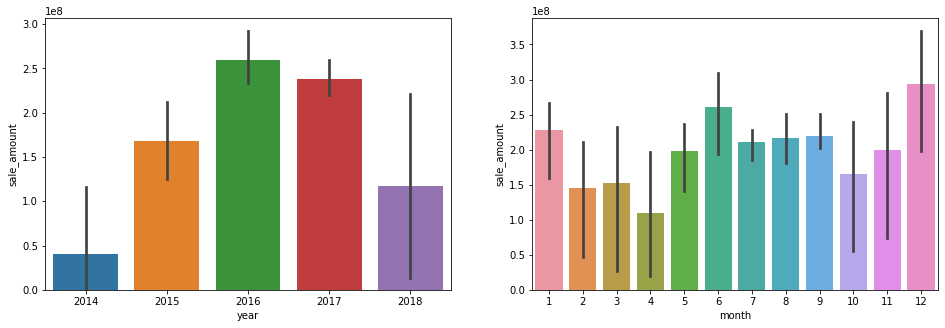

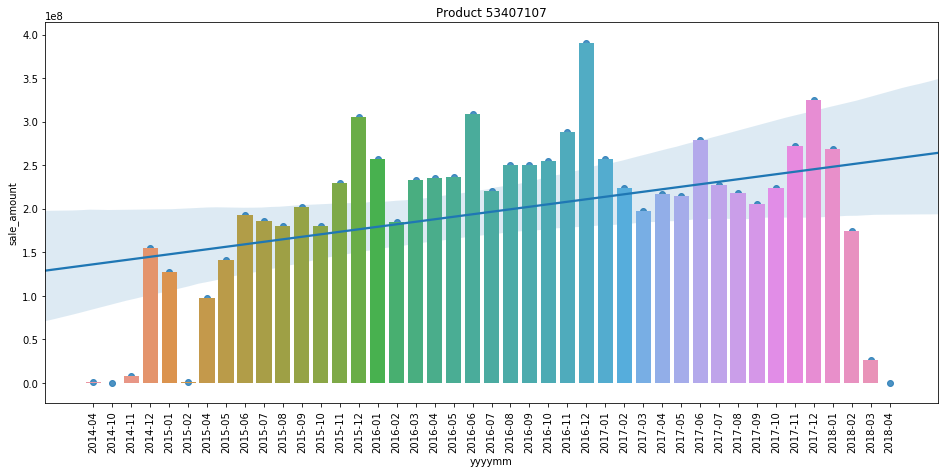

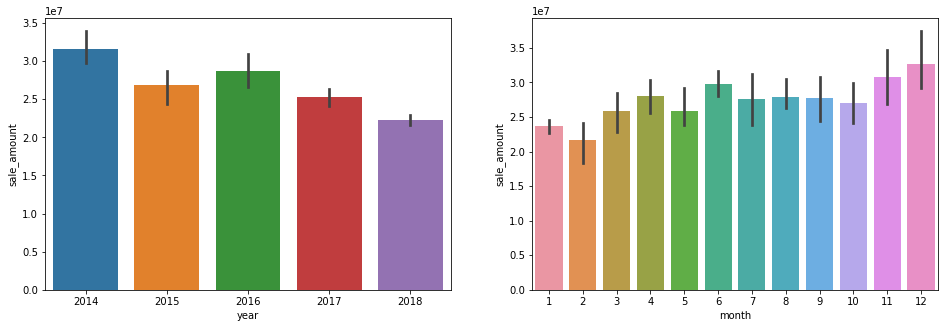

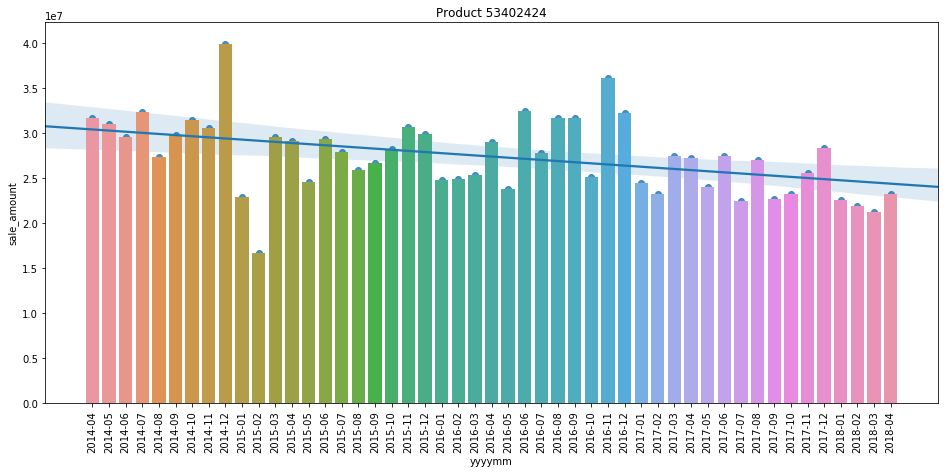

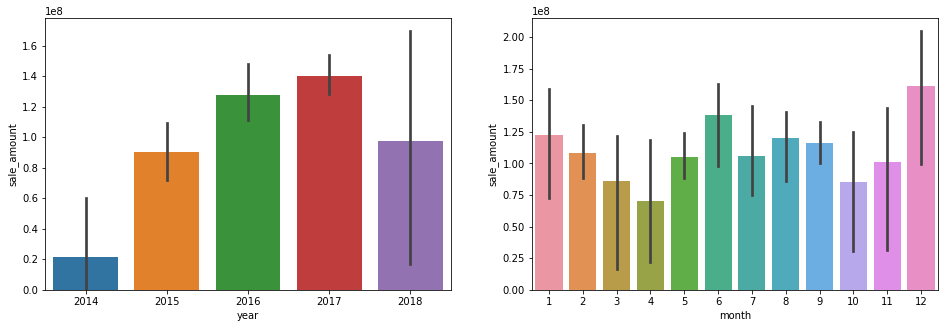

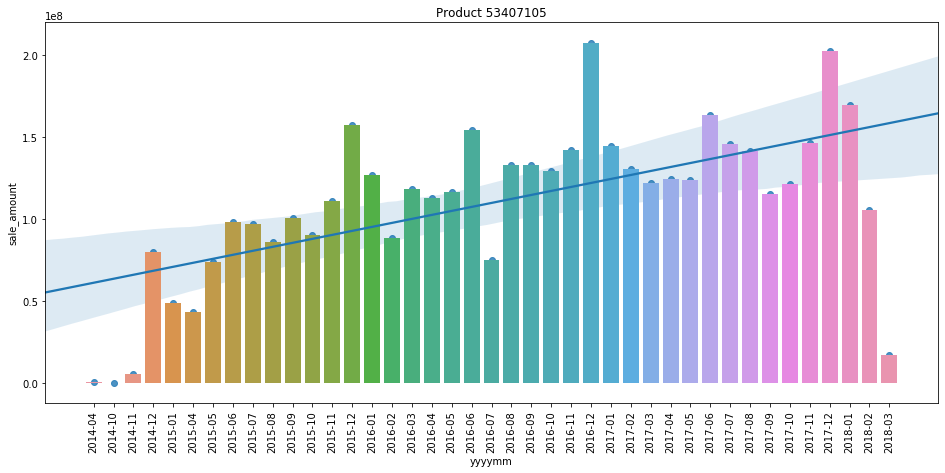

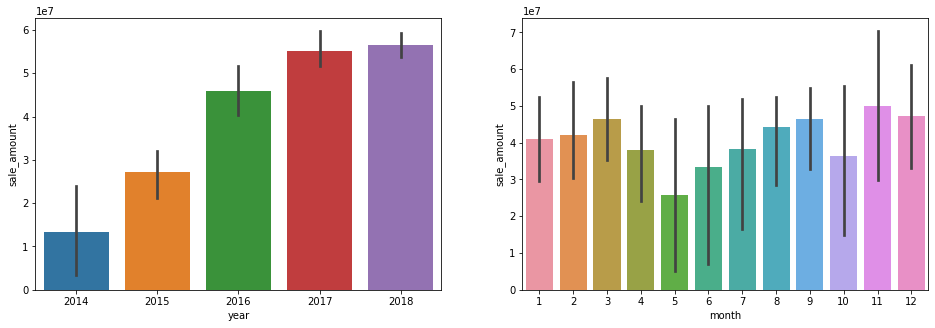

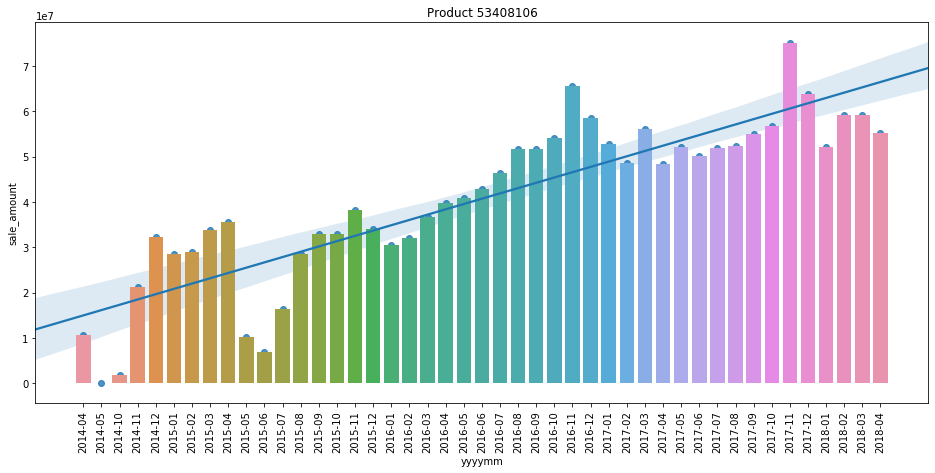

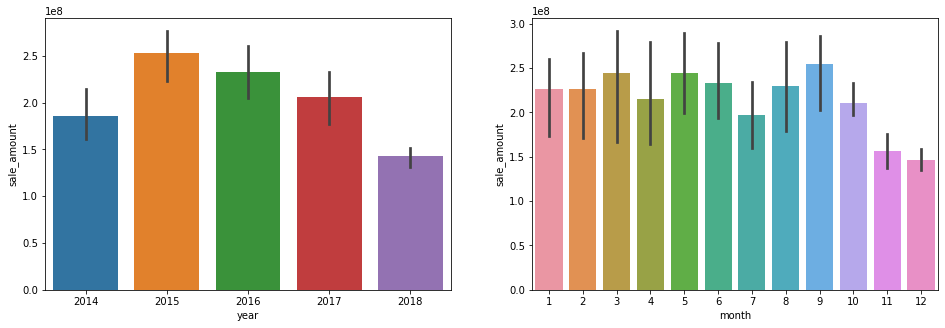

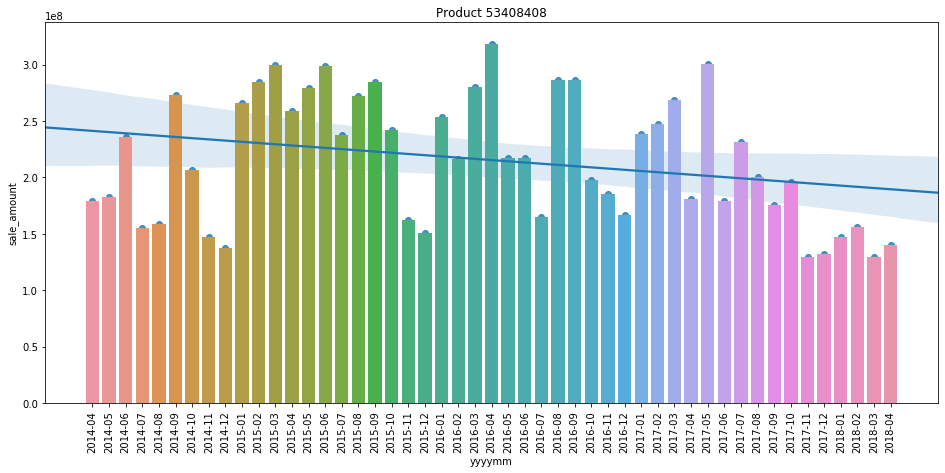

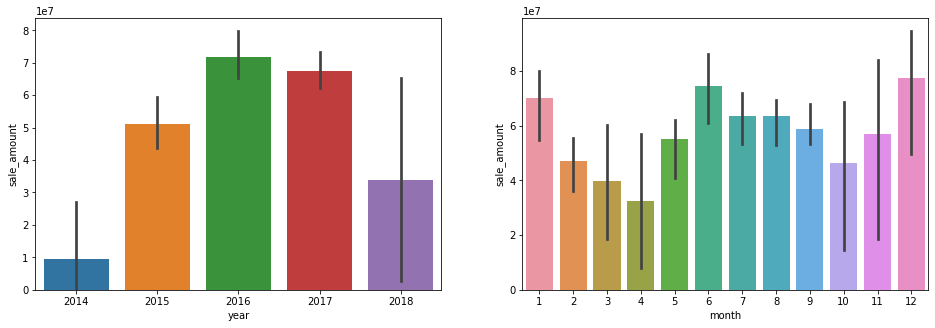

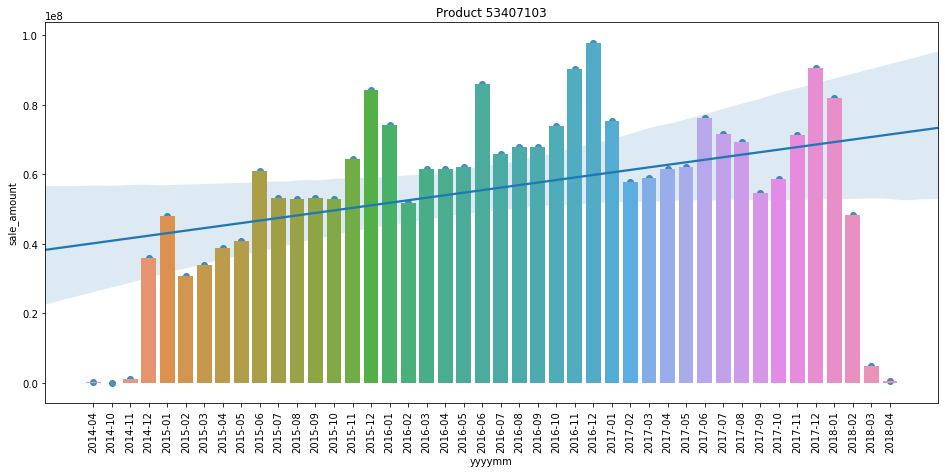

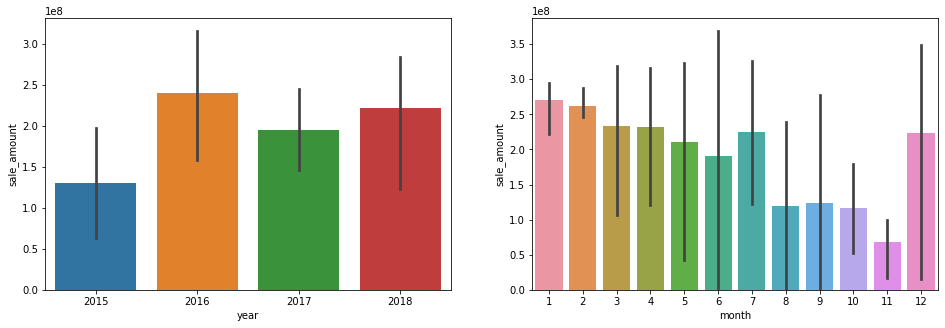

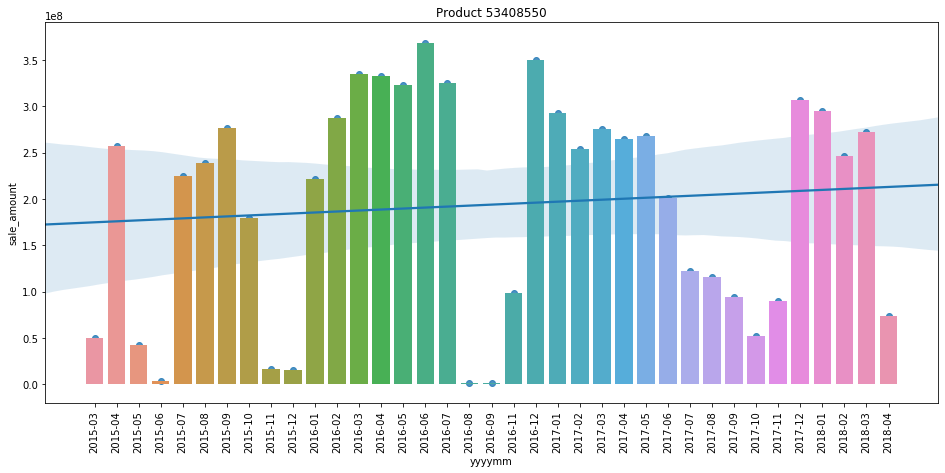

In [18]:
# products = snacks_df['product_id'].unique()
# products = products[np.random.choice(len(products), 10)]
products = top_products_records['product_id'].values

models = {}
for index, product_id in enumerate(products):
    data_df = snacks_df[snacks_df['product_id'] == product_id]
    data_df = data_df.groupby('date')['sale_amount'].sum().reset_index()
    data_df['year'] = data_df['date'].dt.year
    data_df['month'] = data_df['date'].dt.month
    data_df['yyyymm'] = data_df['date'].dt.to_period('M')
#     data_df = data_df[data_df['yyyymm'] >= datetime.date(year=2016, month=1, day=1)].reset_index()
    data_df['log_sale'] = np.log(data_df['sale_amount'])
    data_df['index_value'] = data_df.index
    
    if len(data_df):
        plt.figure(figsize=(16, 5))
        
        plt.subplot(1, 2, 1)
        sns.barplot(x='year', y='sale_amount', data=data_df)
        
        plt.subplot(1, 2, 2)
        sns.barplot(x='month', y='sale_amount', data=data_df)
        plt.show()
        
        plt.figure(figsize=(16, 7))
        chart = sns.barplot(x='yyyymm', y='sale_amount', data=data_df)
        sns.regplot(x = np.arange(0,len(data_df)), y=data_df['sale_amount'], ax=chart)
        chart.set_xticklabels(chart.get_xticklabels(), rotation=90)
        chart.set_title(f"Product {product_id}")
        plt.show()
        
        # How can i make the linear regression??
        models[product_id] = ols('sale_amount ~ index_value', data=data_df).fit()  

With the sum of the units we can see something very similar of what we saw with the count, interesting to notice is the month 8 in 2015, maybe we can check how is that month for other products, maybe that is a month with very big sales in terms of units.

Check what offices are involved in sales that are outliers.

In [40]:
outliers_df.groupby('office')['units'].count().reset_index().rename(columns={ 'units': 'count' }).sort_values('count', ascending=False)

,office,count
1,Medellina,1831
0,Cali,1041
3,Pereira,781
2,Nariño,215


In [41]:
outliers_df.groupby('office')['units'].sum().reset_index().sort_values('units', ascending=False)

,office,units
1,Medellina,281874240
0,Cali,163704672
3,Pereira,115397856
2,Nariño,37700352


Offices that produces more sales are also offices that present the most amount of outliers, there is no sorprise in here.

## Proportion of big sales in terms of numbers of sales

What is the proportion of big sales for all the offices.

In [42]:
count_all_df = product_df.groupby('office')['units'].count().reset_index().rename(columns={ 'units': 'count' })
outlier_count_df = outliers_df.groupby('office')['units'].count().reset_index().rename(columns={ 'units': 'count' })

outlier_count_df['proportion'] = outlier_count_df['count'].values / count_all_df['count'].drop(count_all_df.index[2]).values
outlier_count_df

,office,count,proportion
0,Cali,1041,0.163397
1,Medellina,1831,0.247700
2,Nariño,215,0.250583
3,Pereira,781,0.153438


## Proportion of big sales in terms of quantity

In [43]:
all_units_df = product_df.groupby('office')['units'].sum().reset_index()
outliers_units_df = outliers_df.groupby('office')['units'].sum().reset_index()

outliers_units_df['proportion'] = outliers_units_df['units'].values / all_units_df['units'].drop(all_units_df.index[2]).values
outliers_units_df

,office,units,proportion
0,Cali,163704672,0.965723
1,Medellina,281874240,0.976060
2,Nariño,37700352,0.979707
3,Pereira,115397856,0.957972


Text(0.5, 1.0, 'Sum proportion')

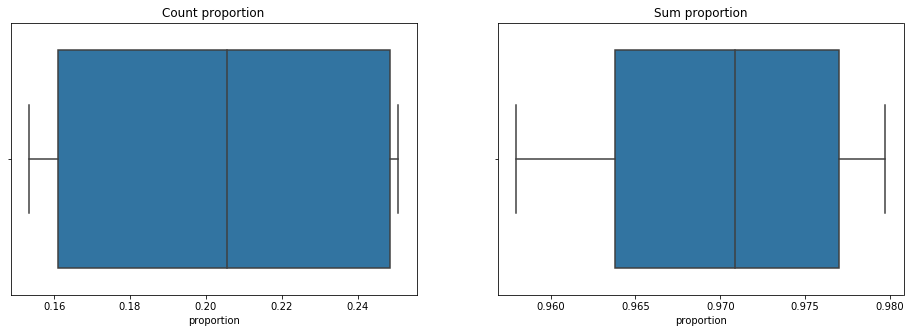

In [44]:
plt.figure(figsize=(16, 5))

plt.subplot(1, 2, 1)
sns.boxplot(outlier_count_df['proportion']).set_title('Count proportion')

plt.subplot(1, 2, 2)
sns.boxplot(outliers_units_df['proportion']).set_title('Sum proportion')

Let's look to clients that buys this kind of quantities.

In [45]:
outliers_df['client'] = outliers_df['client'].fillna('Desconocido')

/Users/juanprq/anaconda3/envs/week8/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [46]:
outliers_df.groupby('client')['units'].count().reset_index().rename(columns={ 'units': 'count' }).sort_values('count', ascending=False)

,client,count
0,Almacenes Exito S.A.,2097
4,Desconocido,1083
6,Supertiendas Y Droguerias Olimpica S.A.,253
3,Colombiana De Comercio S.A.,185
1,Almacenes La 14 S.A.,110
2,Cencosud Colombia S.A.,78
5,Makro Supermayorista S.A.S,62


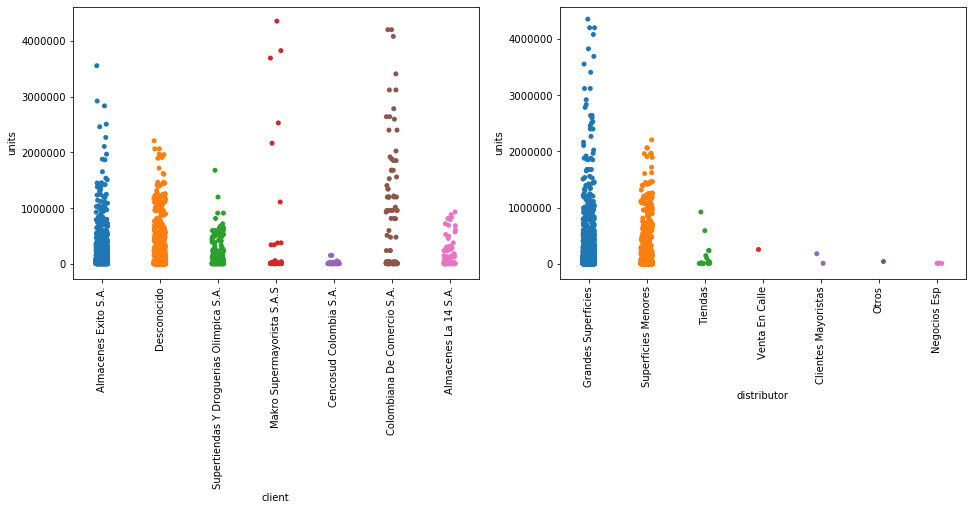

In [47]:
plt.figure(figsize=(16, 5))

plt.subplot(1, 2, 1)
chart = sns.stripplot(x='client', y='units', data=outliers_df)
chart.set_xticklabels(chart.get_xticklabels(), rotation=90)

plt.subplot(1, 2, 2)
chart = sns.stripplot(x='distributor', y='units', data=outliers_df)
chart.set_xticklabels(chart.get_xticklabels(), rotation=90)

plt.show()

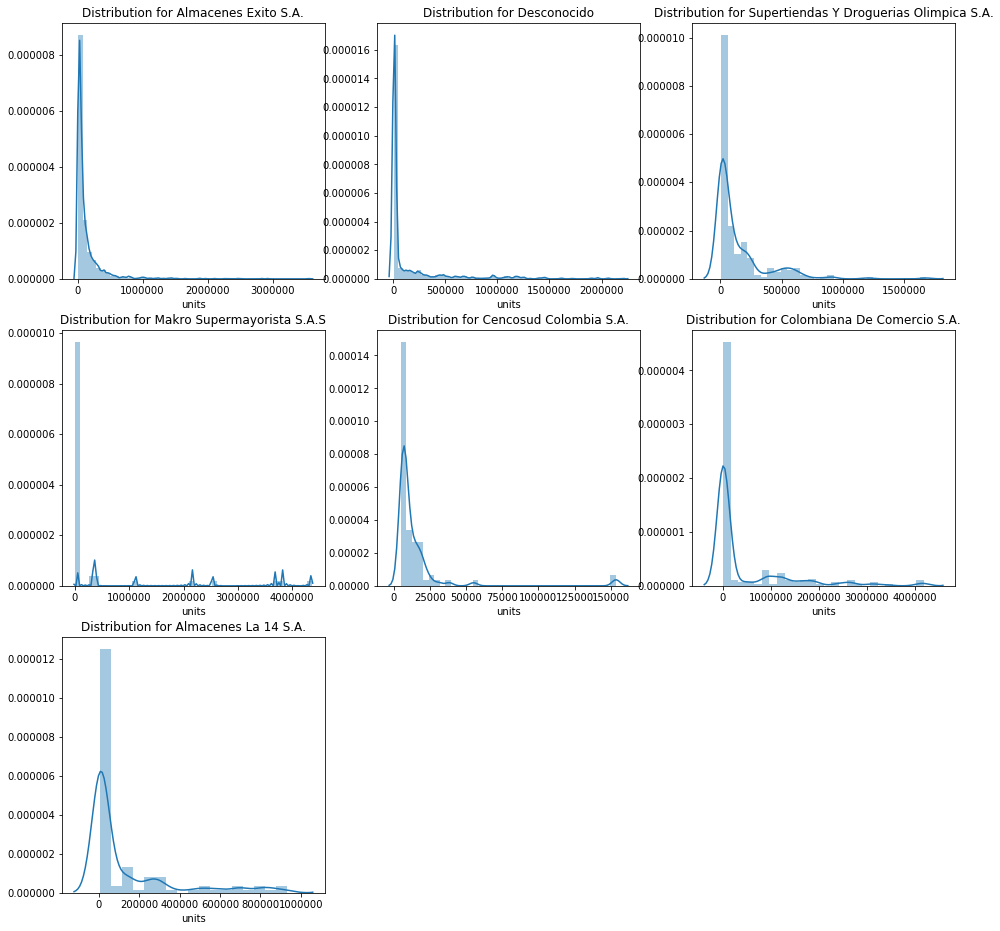

In [48]:
plt.figure(figsize=(16, 16))

for index, client in enumerate(outliers_df['client'].unique()):
    plt.subplot(3, 3, index + 1)
    sns.distplot(outliers_df[outliers_df['client'] == client]['units']).set_title(f"Distribution for {client}")

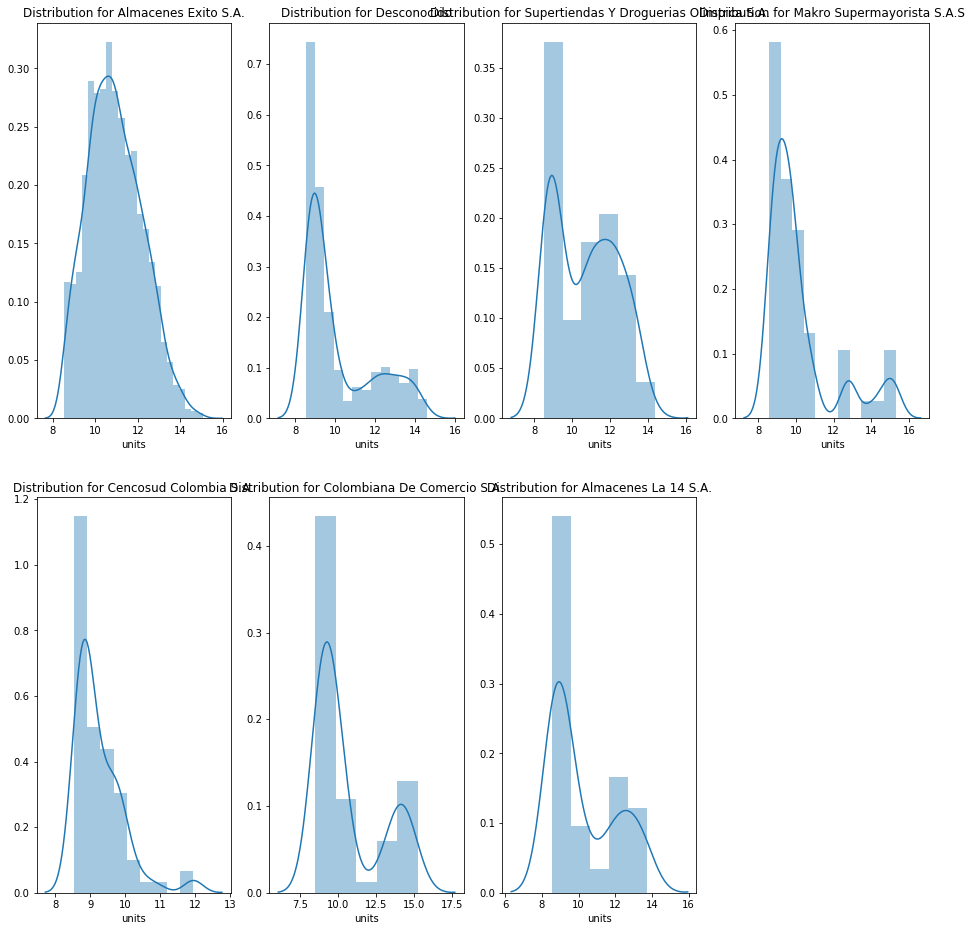

In [49]:
plt.figure(figsize=(16, 16))

for index, client in enumerate(outliers_df['client'].unique()):
    plt.subplot(2, 4, index + 1)
    sns.distplot(np.log(outliers_df[outliers_df['client'] == client]['units'])).set_title(f"Distribution for {client}")

We can see that at least for ever client the outliers sales are different, there are some clients that appear to have a bi-modal distribution.

Since we only have access to clients that are `Grande superficies` we expect this kind of clients to have sales with big volumes, one of the most noticeables is `Almacenes Exito S.A.` how this client behaves interms of sales for this particular product?

In [ ]:
exito_df = outliers_df[(outliers_df['client'] == 'Almacenes Exito S.A.')]

plt.figure(figsize=(16, 16))

plt.subplot(2, 2, 1)
sns.distplot(exito_df['units']).set_title('Exito units distribution')

plt.subplot(2, 2, 2)
sns.distplot(exito_df['sale_amount']).set_title('Exito sales distribution')

plt.subplot(2, 2, 3)
sns.distplot(np.log(exito_df['units'])).set_title('Exito log(units) distribution')

plt.subplot(2, 2, 4)
sns.distplot(np.log(exito_df['sale_amount'])).set_title('Exito log(sales) distribution')

We are seeing that with this particular client and with this particular product the behavior is still the same as the general population. right now we don't have evidence that show us why are this high unit sales are happening.

We can dig more into what is happening in the sale of a particular product in a particular client, so let's choose the client `Exito` with the product `53408408`.

In [ ]:
client_df = product_df[product_df['client'] == 'Almacenes Exito S.A.']

plt.figure(figsize=(16, 10))

plt.subplot(2, 2, 1)
sns.distplot(client_df['units'])

plt.subplot(2, 2, 2)
sns.distplot(client_df['sale_amount'])

plt.subplot(2, 2, 3)
sns.distplot(np.log(client_df['units']))

plt.subplot(2, 2, 4)
sns.distplot(np.log(client_df['sale_amount']))

We are seeing a bi-modal distribution on the logarithmic visualization, maybe this is a good way to fit a clustering algorithm to separate the two distributions.

But first let's try to find patterns using the offices information.

In [ ]:
plt.figure(figsize=(16, 5))

ax = plt.subplot(1, 2, 1)
ax.set_yscale('log')
sns.boxplot(x='office', y='units', data=client_df)

ax = plt.subplot(1, 2, 2)
ax.set_yscale('log')
sns.boxplot(x='office', y='sale_amount', data=client_df)

In [ ]:
plt.figure(figsize=(16, 10))
offices = client_df['office'].unique()

for index, office in enumerate(offices):
    plt.subplot(len(offices), 2, (index * 2) + 1)
    (
        sns.distplot(np.log(client_df[client_df['office'] == office]['units']))
         .set_title(f"log(units) distribution for: {office}")
    )

    plt.subplot(len(offices), 2, (index * 2) + 2)
    (
        sns.distplot(np.log(client_df[client_df['office'] == office]['sale_amount']))
            .set_title(f"log(units) distribution for: {office}")
    )

How is the time series for the specific product, in a specific client for a specific office?

In [ ]:
office_name = 'Medellina'

office_df = client_df[client_df['office'] == office_name]
office_df.head(1)

In [ ]:
data_df = office_df.copy()

data_df['year'] = data_df['date'].dt.year
data_df['month'] = data_df['date'].dt.month
data_df['yyyymm'] = data_df['date'].dt.to_period('M')

plt.figure(figsize=(16, 5))

plt.subplot(1, 2, 1)
sns.barplot(x='year', y='units', data=data_df)

plt.subplot(1, 2, 2)
sns.barplot(x='month', y='units', data=data_df)

plt.figure(figsize=(16, 5))
chart = sns.barplot(x='yyyymm', y='units', data=data_df)
chart.set_xticklabels(chart.get_xticklabels(), rotation=90)
plt.show()

What we have found is that we have a strange behavour in the data previous to `2016`, we have two possible solutions for this, get rid of data prior to `2016` or try to find a way to extract that particular data that have a strange behavior.

One way to possible do this, is to try to find a distribution that describe me and separate the data into the two splits, that way we can have a more uniform and predictive time series.

In [ ]:
plt.figure(figsize=(16, 5))

data_df['log_units'] = np.log(data_df['units'])

chart = sns.barplot(x='yyyymm', y='log_units', data=data_df[data_df['log_units'] < data_df['log_units'].quantile(0.9)])
chart.set_xticklabels(chart.get_xticklabels(), rotation=90)
plt.show()

Separating the data using just the data does not seems to improve the model, we can try a expectation maximization algorithm to try to separate the data assuming that data is described by two gaussian distributions.

In [51]:
snacks_df['log_units'] = np.log(snacks_df['units'])
snacks_df['log_sale'] = np.log(snacks_df['sale_amount'])
snacks_df['year'] = snacks_df['date'].dt.year
snacks_df['month'] = snacks_df['date'].dt.month
snacks_df['yyyymm'] = snacks_df['date'].dt.to_period('M')

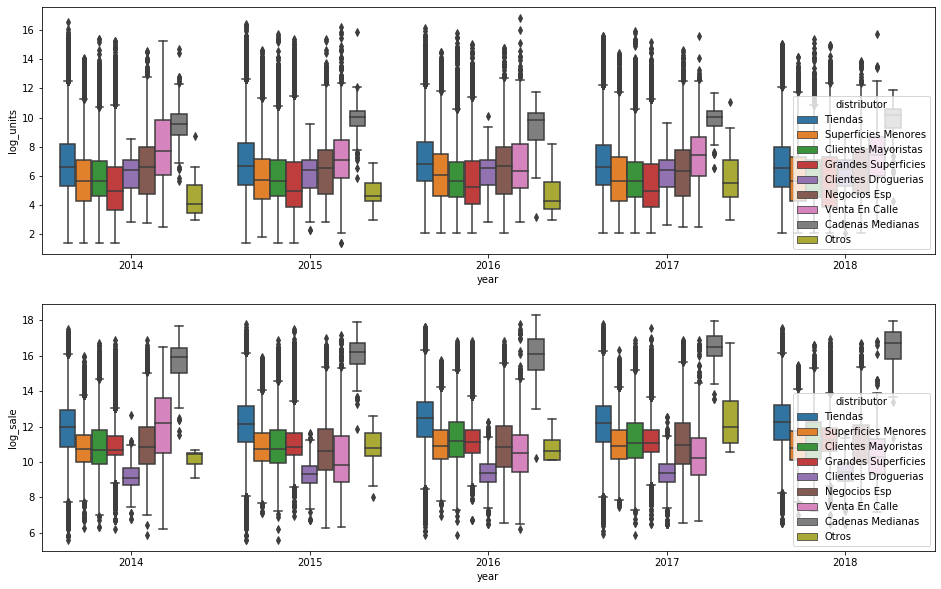

In [52]:
plt.figure(figsize=(16, 10))

plt.subplot(2, 1, 1)
sns.boxplot(x='year', y='log_units', hue='distributor', data=snacks_df)

plt.subplot(2, 1, 2)
sns.boxplot(x='year', y='log_sale', hue='distributor', data=snacks_df)

How about to see each of this distributions and see if we can separate the data?

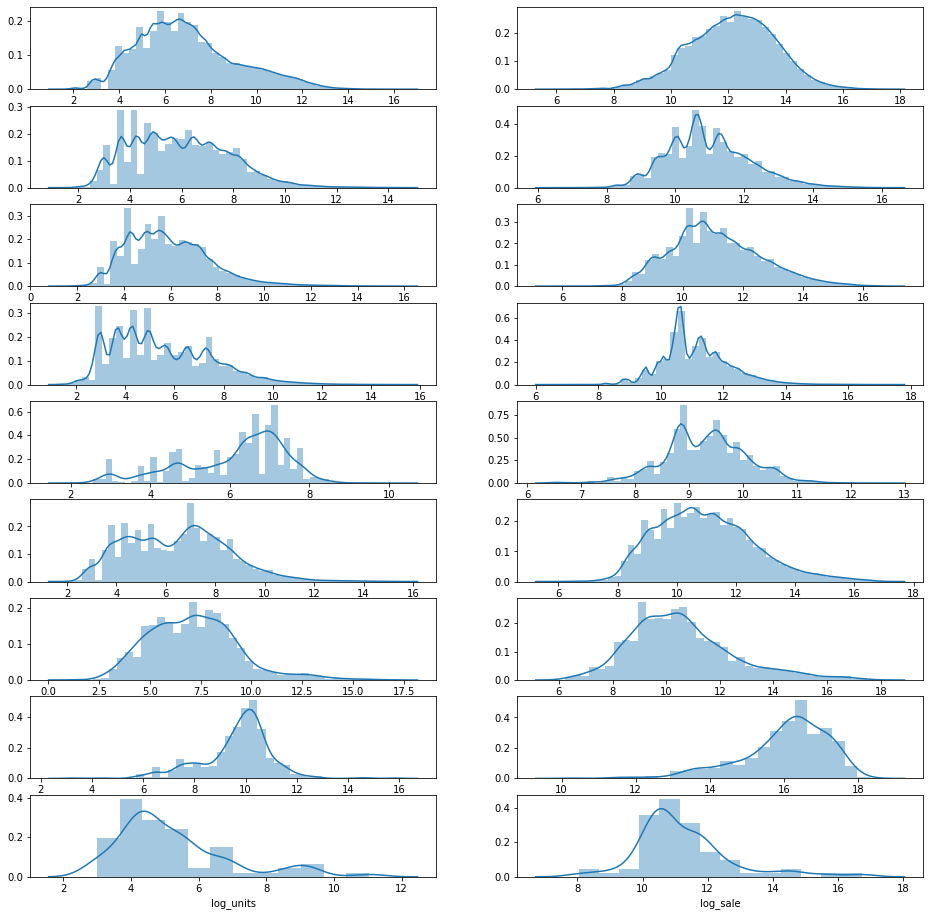

In [53]:
distributors = snacks_df['distributor'].unique()

plt.figure(figsize=(16, 16))
for index, distributor in enumerate(distributors):
    plt.subplot(9, 2, index * 2 + 1)
    sns.distplot(snacks_df[snacks_df['distributor'] == distributor]['log_units'])
    
    plt.subplot(9, 2, index * 2 + 2)
    sns.distplot(snacks_df[snacks_df['distributor'] == distributor]['log_sale'])

Given that distributors behave in a similar way, then we can extract that variable to try to predict behavior of product in each of the products.

Let's try a linear regression using multiple features.

In [ ]:
snacks_df['date_ordinal'] = snacks_df['date'].map(datetime.datetime.toordinal)

ols('sale_amount ~ date_ordinal + product_id', data=snacks_df).fit().summary()

In [19]:
snacks_df['date_ordinal'] = snacks_df['date'].map(datetime.datetime.toordinal)

ols('sale_amount ~ date_ordinal + product_id + distributor', data=snacks_df[snacks_df['product_id'].isin(products)]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            sale_amount   R-squared:                       0.123
Model:                            OLS   Adj. R-squared:                  0.123
Method:                 Least Squares   F-statistic:                     1846.
Date:                Tue, 10 Dec 2019   Prob (F-statistic):               0.00
Time:                        15:41:33   Log-Likelihood:            -3.5644e+06
No. Observations:              237076   AIC:                         7.129e+06
Df Residuals:                  237057   BIC:                         7.129e+06
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
======================================================================================================
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
Intercept                          -4.395e+07   3.33e+06    -13.205      0.000   -5.05e+07   -3.74e+07
product_id[T.53402424]             -1.662e+05   7427.749    -22.382      0.000   -1.81e+05   -1.52e+05
product_id[T.53407103]             -3.035e+05   7626.487    -39.792      0.000   -3.18e+05   -2.89e+05
product_id[T.53407105]             -2.304e+05   7472.586    -30.827      0.000   -2.45e+05   -2.16e+05
product_id[T.53407107]             -8.867e+04   6872.948    -12.902      0.000   -1.02e+05   -7.52e+04
product_id[T.53407109]             -4499.6668   6811.310     -0.661      0.509   -1.78e+04    8850.324
product_id[T.53408106]             -2.505e+05   7573.986    -33.079      0.000   -2.65e+05   -2.36e+05
product_id[T.53408407]              1.015e+05   6763.333     15.004      0.000    8.82e+04    1.15e+05
product_id[T.53408408]              3.227e+05   7786.400     41.440      0.000    3.07e+05    3.38e+05
product_id[T.53408550]             -3.815e+04   7671.020     -4.973      0.000   -5.32e+04   -2.31e+04
distributor[T.Clientes Droguerias] -7.317e+06   1.64e+05    -44.521      0.000   -7.64e+06   -6.99e+06
distributor[T.Clientes Mayoristas] -7.245e+06   1.64e+05    -44.175      0.000   -7.57e+06   -6.92e+06
distributor[T.Grandes Superficies] -7.248e+06   1.64e+05    -44.225      0.000   -7.57e+06   -6.93e+06
distributor[T.Negocios Esp]         -7.21e+06   1.64e+05    -43.923      0.000   -7.53e+06   -6.89e+06
distributor[T.Otros]               -5.581e+06   2.96e+05    -18.833      0.000   -6.16e+06      -5e+06
distributor[T.Superficies Menores] -7.222e+06   1.64e+05    -44.062      0.000   -7.54e+06    -6.9e+06
distributor[T.Tiendas]             -6.664e+06   1.64e+05    -40.660      0.000   -6.99e+06   -6.34e+06
distributor[T.Venta En Calle]      -5.815e+06   1.67e+05    -34.871      0.000   -6.14e+06   -5.49e+06
date_ordinal                          69.8238      4.515     15.464      0.000      60.974      78.673
==============================================================================
Omnibus:                   463594.124   Durbin-Watson:                   1.837
Prob(Omnibus):                  0.000   Jarque-Bera (JB):       1865791891.958
Skew:                          15.462   Prob(JB):                         0.00
Kurtosis:                     436.502   Cond. No.                     1.46e+09
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.46e+09. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

I don't want to expend more time in this prediction, this is as good as it can gets based on the data that we have, we are going to present this as the prediction model.